In [88]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize
import os

Load and Preprocess Images

In [89]:
def load_and_process_image(path_to_img):
    max_dim = 512
    img = load_img(path_to_img)
    img = img_to_array(img)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return vgg19.preprocess_input(img)

content_path = "/content/sample_data/content_1.jpg"
style_path = "/content/sample_data/style_3.png"

content_image = load_and_process_image(content_path)
style_image = load_and_process_image(style_path)


## Load Pre-trained VGG19 and Extract Style & Content Layers
Define which layers to use

In [90]:
# Content layer and multiple style layers from VGG19
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


Load the model and extract outputs

In [91]:
def vgg_layers(layer_names):
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = Model([vgg.input], outputs)
    return model

# Style + content extractor
style_extractor = vgg_layers(style_layers)
content_extractor = vgg_layers(content_layers)


Gram Matrix (for style representation)

In [92]:
def gram_matrix(input_tensor):
    if len(input_tensor.shape) == 3:
        input_tensor = tf.expand_dims(input_tensor, 0)  # Add batch dim

    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations


Extract Style and Content Features

In [93]:
def get_feature_representations(model, content_path, style_path):
    content_image = load_and_process_image(content_path)
    style_image = load_and_process_image(style_path)

    # Stack into batch format (1 image)
    style_outputs = model(style_image)
    content_outputs = model(content_image)

    style_features = [style_layer for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer for content_layer in content_outputs[num_style_layers:]]

    return content_features, style_features


Define Loss Functions

In [94]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    for target_style, comb_style in zip(gram_style_features, style_output_features):
        comb_gram = gram_matrix(comb_style)
        style_score += tf.reduce_mean((comb_gram - target_style) ** 2)

    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += tf.reduce_mean((comb_content - target_content) ** 2)

    style_score *= style_weight / num_style_layers
    content_score *= content_weight / num_content_layers

    loss = style_score + content_score
    return loss, style_score, content_score


## Optimize the Stylized Image
Prepare everything for training:

In [95]:
# Combine both models into one
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    return Model(vgg.input, model_outputs)

# Extract features
model = get_model()
for layer in model.layers:
    layer.trainable = False

content_features, style_features = get_feature_representations(model, content_path, style_path)

# Gram matrices of style features
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

# Init image (starting point for optimization)
init_image = load_and_process_image(content_path)
init_image = tf.Variable(init_image, dtype=tf.float32)

# Set weights
style_weight = 1e-2
content_weight = 1e4


Optimization Function

In [96]:
@tf.function()
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_outputs = cfg['model'](cfg['init_image'])
        style_outputs = all_outputs[:num_style_layers]
        content_outputs = all_outputs[num_style_layers:]

        loss, style_score, content_score = compute_loss(
            cfg['model'], cfg['loss_weights'], cfg['init_image'],
            cfg['gram_style_features'], cfg['content_features']
        )
    grads = tape.gradient(loss, cfg['init_image'])
    return grads, loss


Train Loop

In [97]:
import time

def run_style_transfer(model, content_features, gram_style_features,
                       init_image, num_iterations=1000, content_weight=1e4, style_weight=1e-2):
    opt = tf.optimizers.Adam(learning_rate=5.0)

    best_loss, best_img = float('inf'), None

    cfg = {
        'model': model,
        'loss_weights': (style_weight, content_weight),
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    for i in range(num_iterations):
        grads, loss = compute_grads(cfg)
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, -128.0, 128.0)
        init_image.assign(clipped)

        if loss < best_loss:
            best_loss = loss
            best_img = init_image.numpy()

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss:.4f}")

    return best_img


Deprocessing and Display Function

In [98]:
def deprocess_img(processed_img):
    x = processed_img.copy().reshape((processed_img.shape[1], processed_img.shape[2], 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def show_image(img, title='Image'):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()


### Run It!

Iteration 0, Loss: 17501692.0000
Iteration 100, Loss: 12662692.0000
Iteration 200, Loss: 10485468.0000
Iteration 300, Loss: 9378874.0000
Iteration 400, Loss: 10643743.0000
Iteration 500, Loss: 8824699.0000
Iteration 600, Loss: 8166667.0000
Iteration 700, Loss: 7777565.0000
Iteration 800, Loss: 7505472.5000
Iteration 900, Loss: 7493056.0000


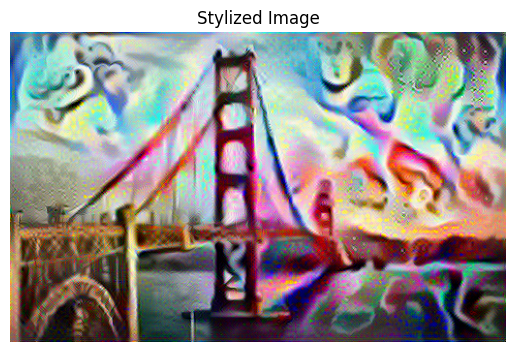

In [100]:
best = run_style_transfer(model, content_features, gram_style_features, init_image,) #num_iterations = 100)
output = deprocess_img(best)
show_image(output, "Stylized Image")
